# Exercise: Grid world

Objective: Understanding RL algorithms in a simple grid MDP

In [ ]:
import random, time, math
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

# random seed
random.seed(20191204)

def plotdata(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

## Environment

Grid world model

rows x cols cells

State: (r,c)

Init: (0,0)    Goal: (rows-1, cols-1)

In [ ]:
class GridWorld:
  def __init__(self, rows=3, cols=4):
    self.rows = rows
    self.cols = cols
    self.ns = self.rows * self.cols # nr. of states
    self.actionnames = ['L','R','U','D']
    self.na = len(self.actionnames) # nr. of actions
    self.reset()

  def state_space(self):
    return range(0,self.ns)

  def action_space(self):
    return range(0,self.na)

  def action_sample(self):
    return random.randrange(0,self.na)

  def encode(self):
    return self.state[0]+self.state[1]*self.rows

  def render(self):
    print('S: %d,%d (enc: %d)' %(self.state[0], self.state[1], self.encode()))

  def reset(self):
    self.state = [0,0]
    return self.encode()

  def step(self, a):
    # transition
    if a==0 and self.state[1]>0: # L
      self.state[1] -= 1
    elif a==1 and self.state[1]<self.cols-1:  # R
      self.state[1] += 1
      if self.state[1]==0 and random.random()<0.2:
        self.state[1] += 1
    elif a==2 and self.state[0]<self.rows-1: # U
      if random.random()<0.9:
        self.state[0] += 1
    elif a==3 and self.state[0]>0: # D
      self.state[0] -= 1
    s = self.encode()

    # reward, done
    if self.state == [self.rows-1,self.cols-1]:
      r = 100
      done = True
    else:  
      r = 0
      done = False
    
    return s,r,done

env = GridWorld(10,10)
ns = len(env.state_space())
na = len(env.action_space())


## Environment test

In [ ]:
done = False
T = 100
t = 0
s = env.reset()
#env.render()
while t<T and not done:
  a = env.action_sample()  # L, R, U, D
  s1,r,done = env.step(a) 
  #env.render()
  s = s1
  t += 1
  time.sleep(0.1)

print('%3d - %d %d %.1f %d %d' %(t,s,a,r,s1,done))


100 - 42 2 0.0 42 0


## Agent

In [ ]:
class Agent:
  def __init__(self, nstates, nactions, epsilon=0.1, gamma=0.9, edecay = False, UCB=False):
    self.nstates = nstates
    self.nactions = nactions
    self.epsilon = epsilon
    self.gamma = gamma
    self.UCB = UCB
    self.edecay = edecay
    self.C = defaultdict(lambda: defaultdict(int))  # state-action visit counter
    self.Q = defaultdict(lambda: defaultdict(float)) # action-value table
  
  def choose(self,s,optimal=False):
    if optimal:
      Qv = [self.Q[s][k] for k in range(0,self.nactions)]
      return np.argmax(Qv)

    r = random.random()
    if r < self.epsilon:
      a = random.randrange(0,self.nactions)
    else:
      Qv = [self.Q[s][k] for k in range(0,self.nactions)]
      Z = np.array(Qv)
      m = np.max(Qv)
      if self.UCB and m>0:
        beta = 1.0
        t = np.sum([v for v in self.C[s].values()])
        Uv = [0 if self.C[s][k]==0 else math.sqrt(beta * math.log(t) / (2 * self.C[s][k]))  for k in range(0,self.nactions)]
        Z = np.array(Qv)/np.max(Qv) + np.array(Uv)
        m = np.max(Z)
      maxs = [k for k in range(0,self.nactions) if m == Z[k]]
      a = random.choice(maxs)
    #print('action %d' %a)
    return a

  def update(self,s,a,r,s1,done):
      self.C[s][a] += 1
      a1 = self.choose(s1)
      ret = r + self.gamma * self.Q[s1][a1]
      alpha = 1.0/self.C[s][a]
      self.Q[s][a] = self.Q[s][a] + alpha * (ret - self.Q[s][a])
      if done and self.edecay:
        self.epsilon = max(0.1, self.epsilon*0.99)



## Training set-up

In [ ]:
epsilon = [0.0,   # only exploitation (greedy)
           0.1,   # combine exploration and exploitation
           1.0]   # only exploration (random)
gamma = 0.99

# set of experiments to run
# each experiment: [agent, label, reward history]
experiments = []
for e in epsilon:
  agent = Agent(ns,na,e,gamma)
  label = 'e %.2f' %e
  rh = []
  experiments.append([agent, label, rh])

agent = Agent(ns,na,0.9,gamma,edecay=True,UCB=False)  
experiments.append([agent, 'decay 0.9', []])
agent = Agent(ns,na,0.0,gamma,edecay=False,UCB=True)  
experiments.append([agent, 'UCB', []])


## Training

In [ ]:
def oneepisode(optimal=False):
  rs = 0
  done = False
  s = env.reset()
  g = 1
  Tmax = 100
  t = 0
  while not done and t<Tmax:
    a = agent.choose(s,optimal)
    s1,r,done = env.step(a)
    agent.update(s,a,r,s1,done)
    #env.render()
    s = s1
    rs += g * r
    g *= agent.gamma
    t += 1
  return rs

T = 500
optimal = False

for exp in experiments:
  agent = exp[0]
  rh = exp[2]
  for t in range(T):
    print('*', end='')
    rs = oneepisode(optimal)
    rh.append(rs)
    time.sleep(0.01)

  print('\n')
  #print(rh)

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

## Results

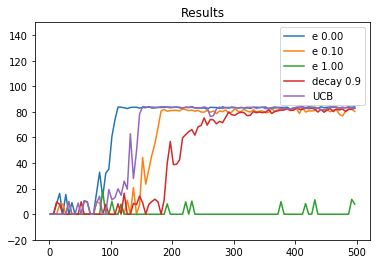

In [ ]:
plt.title('Results')
plt.ylim(bottom = -20, top = 150)

for exp in experiments:
  rh = exp[2]
  lab = exp[1]
  t,y = plotdata(rh, d=5)
  plt.plot(t, y, label=lab)

plt.legend()
plt.show()